[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3694, number of used features: 8
[LightGBM] [Info] Start training from score 74.527454


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


      Date  Actual Price  Predicted Price
2025-03-03    154.050003       157.249406
2025-03-04    153.169998       156.283708
2025-03-05    158.949997       159.997682
2025-03-06    161.460007       164.114156
2025-03-07    158.139999       156.827197
2025-03-10    155.139999       153.179629
2025-03-11    156.779999       155.329207
2025-03-12    159.199997       156.088673
2025-03-13    157.960007       158.357163
2025-03-17    156.580002       156.535631
2025-03-18    156.580002       155.837352
2025-03-19    165.960007       168.025546
2025-03-20    168.460007       166.826611
2025-03-21    175.050003       175.776200
2025-03-24    181.279999       184.521553
2025-03-25    177.699997       177.982034
2025-03-26    174.070007       172.653233
2025-03-27    181.559998       180.733230
2025-03-28    183.039993       182.101357


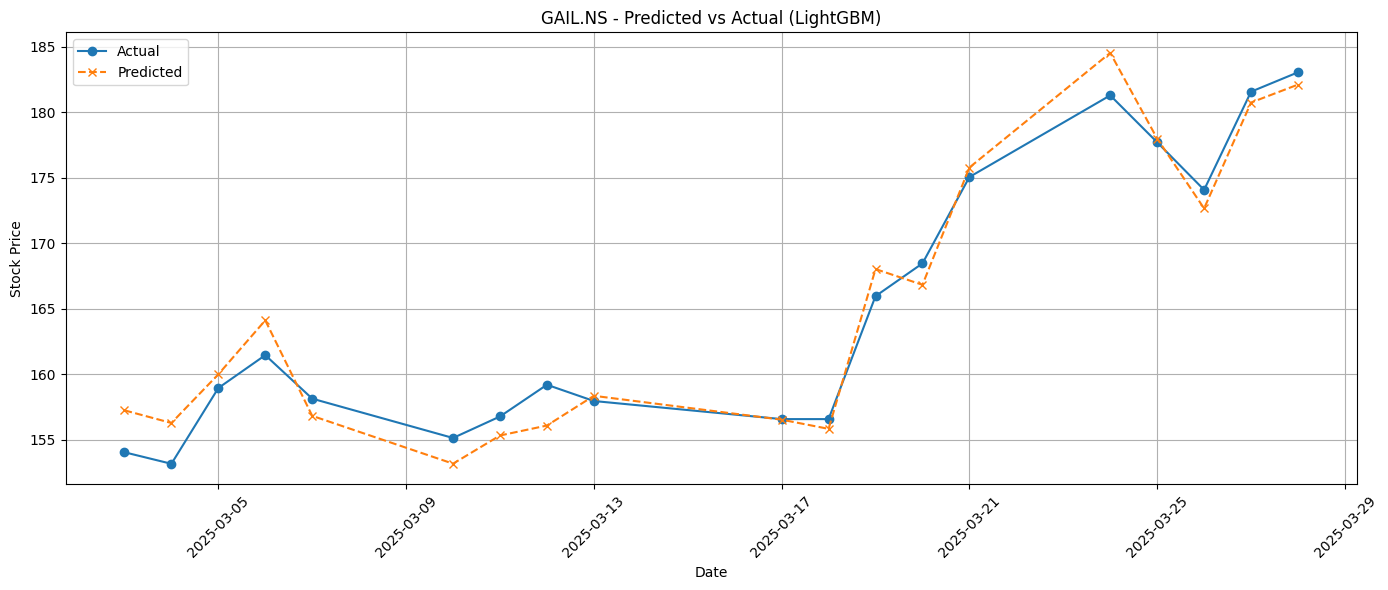


Evaluation Metrics:
RMSE: 1.8884
MAE: 1.5876
R² Score: 0.9656


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Step 1: Download data
stock_symbol = "GAIL.NS"
start_date = "2010-01-01"
end_date = "2025-04-01"
df = yf.download(stock_symbol, start=start_date, end=end_date)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Step 2: Feature Engineering
df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Return'].rolling(window=5).std()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df = df.dropna()

# Step 3: Create features and target
features = ['Open', 'High', 'Low', 'Volume', 'Return', 'Volatility', 'MA_10', 'MA_50']
X = df[features]
y = df['Close']

# Step 4: Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train-test split
split_date = "2025-03-01"
X_train = X[df.index < split_date]
X_test = X[df.index >= split_date]
y_train = y[df.index < split_date]
y_test = y[df.index >= split_date]

# Re-apply scaler after split to avoid data leakage
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train LightGBM model
model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05)
model.fit(X_train_scaled, y_train)

# Step 7: Predict
y_pred = model.predict(X_test_scaled)

# Step 8: Results
dates_test = df[df.index >= split_date].index
df_results = pd.DataFrame({
    'Date': dates_test,
    'Actual Price': y_test.values.flatten(),
    'Predicted Price': y_pred.flatten()
})
print(df_results.to_string(index=False))

# Step 9: Plot
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test.values, label='Actual', marker='o')
plt.plot(dates_test, y_pred, label='Predicted', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{stock_symbol} - Predicted vs Actual (LightGBM)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
